In [97]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.spatial import distance
from scipy import ndimage
from random import random
from sklearn.cluster import SpectralBiclustering
import itertools

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib
import scoring
import rda

#from pyvis.network import Network
import networkx as nx
import plotly.graph_objects as go

In [98]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [99]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [100]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

49 participants total


In [101]:
def convert_to_str(flat_world):
    s = [str(i) for i in list(flat_world)] 
    res = "".join(s)
    return res

In [102]:
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())

dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

dfic = dfi[dfi.condition=='repeated']
dfic = dfic[['targetName','gameID','blockNum','repetition','flatDiscreteWorld','usableDiscreteWorld','rawF1DiscreteScore']]
dfic['discreteWorld'] = dfic['usableDiscreteWorld']
dfic['flatDiscreteWorldStr'] = dfic['flatDiscreteWorld'].apply(convert_to_str)

max_actions = dfic['blockNum'].max()

In [ ]:
# need an easy way of representing thickness of lines between two nodes

In [ ]:
class Node:
    '''
    Represents a world state (as defined by discrete bitmap representation of blocks present, 
        as opposed to individual block dimensions and locations).
    Each Node can have multiple children.
    '''
    
    def __init__(self, flat_world):
        self.out_edges = [] #list of edges (child, ppt, rep)
        self.flat_world = flat_world 
        self.flat_world_str = convert_to_str(flat_world)
        self.world_size = np.sum(flat_world)
        self.x = 0
        self.y = self.world_size
        
    def __str__(self):
        return('Node of size ' + str(self.world_size))
    
    def __repr__(self):
        return('Node of size ' + str(self.world_size))

    #def get_ppts(self):
        #self.out_edges.m
        
    def add_child(self, node, ppt, rep, block_num):
        self.out_edges.append(Edge(self, node, ppt, rep, block_num))

In [ ]:
class Edge:
    '''
    Edges contain child nodes, as well as the (ppt, repetition) pair that 
        uniquely defines a building path in the experiment (for one structure)
    '''
    def __init__(self, source, target, ppt, rep, block_num):
        self.source = source
        self.target = target
        self.ppt = ppt
        self.rep = rep
        self.block_num = block_num
        print('created edge: ' + str(self))
        
    def __str__(self):
        return('Block ' + str(self.block_num) + ', ppt: ' + self.ppt + ', rep: ' + str(self.rep))
    
    def __repr__(self):
        return('Block ' + str(self.block_num) + ', ppt: ' + self.ppt + ', rep: ' + str(self.rep))


In [ ]:
class WorldLayer:
    '''
    Height in a tree is set by the sum of covered squares in the bitmap representation of the world.
    WorldLayer contains a dictionary that maps a flatdiscreteworld to a Node object
    '''
    def __init__(self, num_squares):
        self.num_squares = num_squares
        self.nodes = {}
        
    def __str__(self):
        return(str(len(self.nodes)) + ' nodes in layer')
    
    def __repr__(self):
        return(str(len(self.nodes)) + ' nodes in layer')
    
    def get_world_node(self, flat_world):
        '''
        add world state into layer
        if already exists, then returns the existing node.
        otherwise, creates new node and returns it
        
        '''
        flat_world_str = convert_to_str(flat_world)
        if flat_world_str in self.nodes:
            existing_node = self.nodes[flat_world_str]
            return existing_node
        else:
            new_node = Node(flat_world)
            self.nodes[flat_world_str] = new_node
            return new_node

In [ ]:
class BuildTree:
    def __init__(self, target_name):
        self.target_name = target_name
        self.world_layers = {} #dict.fromkeys(range(0, 80, 2))
        self.world_layers[0] = WorldLayer(0) # layers to allow quick indexing of world state
        
        # Add layer for every multiple of two, or add manually?
        
        self.root = self.world_layers[0].get_world_node(np.zeros(13*18).astype(int)) # start with one node with empty world
        self.prev_node = self.root
        
        
    def __str__(self):
        return('Tree for ' + self.target_name + ': \n' + str(self.root) + '\nLayers: ' + str(self.world_layers))
    
    def add_block_placement(self, discrete_world, discrete_world_str, ppt, rep, block_num):
        # fetch correct node (or create new one)
        world_squares = np.sum(discrete_world)
        if not(world_squares in self.world_layers): #if layer doesn't exist, add layer
            self.world_layers[world_squares] = WorldLayer(world_squares)
            
        # get node for this world state (if exists)
        new_node = self.world_layers[world_squares].get_world_node(discrete_world)
        
        # link previous nodes to current node
        self.prev_node.add_child(new_node, ppt ,rep, block_num)
        self.prev_node = new_node
        
    def reset_prev_node(self):
        '''
        Reset pointer to previous node
        '''
        self.prev_node = self.root
        
        #print(discrete_world, discrete_world_str, ppt, rep)
        
    def add_build_path(self, df):
        '''
        adds series of block placements from dataframe (for one build sequence) to the tree
        '''
        df.apply(lambda r: self.add_block_placement(r.flatDiscreteWorld,
                                        r.flatDiscreteWorldStr,
                                        r.gameID,
                                        r.repetition,
                                        r.blockNum), axis=1)
        self.reset_prev_node()
        
    def get_coords(self):
        node_xs = []
        node_ys = []
        edge_xs = []
        edge_ys = []
        
        for i, (k1, layer) in enumerate(self.world_layers.items()):
            for j, (k2, node) in enumerate(layer.nodes.items()):
                n_x = (j+1)/(len(layer.nodes)+1) #12 should be max width
                n_y = layer.num_squares
                node.x = n_x
                node.y = n_y
                node_xs.append(n_x)
                node_ys.append(n_y)
        
        for i, (k1, layer) in enumerate(self.world_layers.items()):
            for j, (k2, node) in enumerate(layer.nodes.items()):
                parent_x = node.x
                parent_y = node.y
                for _, e in enumerate(node.out_edges):
                    child_y = e.target.y
                    child_x = e.target.x
                    edge_xs.append(parent_x)
                    edge_xs.append(child_x)
                    edge_xs.append(None)
                    edge_ys.append(parent_y)
                    edge_ys.append(child_y)
                    edge_ys.append(None)
                
        return (node_xs, node_ys, edge_xs, edge_ys)

In [ ]:
t = BuildTree(targets[5])

In [ ]:
# Add all build paths for one target during one rep
t = BuildTree(targets[5]) # make new tree

target = targets[5]
rep = 0

a = dfic[(dfic.targetName==target) & (dfic.repetition==rep)]
a = a.groupby('gameID')
a.apply(lambda g: t.add_build_path(g))

In [ ]:
node_xs, node_ys, edge_xs, edge_ys  = t.get_coords()


edge_trace = go.Scatter(
    x=edge_xs, y=edge_ys,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=node_xs, y=node_ys,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
#         colorbar=dict(
#             thickness=15,
#             title='Node Connections',
#             xanchor='left',
#             titleside='right'
#         ),
        line_width=2))

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>World states for target 0, repetition 1, by number of squares',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                #yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                
                )

fig.update_layout(
    width=800,
    height=800
)

fig.show()

In [ ]:
Understand the distribution of action sequences that people take to build a structure

## More generic graph

Create and display a graph of building trajectories
This graph should have the flexibility to specify different dimensions for x and y,
although what defines a node will always be the world state

In [103]:
class GenericNode:
    '''
    Represents a world state (as defined by discrete bitmap representation of blocks present, 
        as opposed to individual block dimensions and locations).
    Each Node can have multiple children.
    '''
    
    def __init__(self, discrete_world, f1_score):
        self.out_edges = [] #list of edges (child, ppt, rep)
        self.discrete_world = discrete_world 
        self.world_str = convert_to_str(discrete_world)
        #self.world_size = np.sum(flat_world) #shouldn't be needed in this
        self.f1_score = f1_score
        self.visits = 1
        
        self.y = self.f1_score
        #self.x = np.sum(discrete_world)
        
        self.x = ndimage.measurements.center_of_mass(discrete_world)[0]
        
        if np.isnan(self.x):
            self.x = 8.5
        
    def __str__(self):
        return('Node of size ' + str(self.world_size))
    
    def __repr__(self):
        return('Node of size ' + str(self.world_size))

    #def get_ppts(self):
        #self.out_edges.m
        
    def add_child(self, node, ppt, rep, block_num):
        self.out_edges.append(GenericEdge(self, node, ppt, rep, block_num))
    
    def visit(self):
        self.visits +=1

In [104]:
class GenericEdge:
    '''
    Edges contain child nodes, as well as the (ppt, repetition) pair that 
        uniquely defines a building path in the experiment (for one structure)
    '''
    def __init__(self, source, target, ppt, rep, block_num):
        self.source = source
        self.target = target
        self.ppt = ppt
        self.rep = rep
        self.block_num = block_num
        
    def __str__(self):
        return('Block ' + str(self.block_num) + ', ppt: ' + self.ppt + ', rep: ' + str(self.rep))
    
    def __repr__(self):
        return('Block ' + str(self.block_num) + ', ppt: ' + self.ppt + ', rep: ' + str(self.rep))


In [105]:
class GenericWorldLayer:
    '''
    In previous iterations of graph this was used to group nodes by y-axis.
    Now here to allow faster access to nodes 
    '''
    def __init__(self, num_squares):
        self.num_squares = num_squares
        self.nodes = {}
        
    def __str__(self):
        return(str(len(self.nodes)) + ' nodes in layer')
    
    def __repr__(self):
        return(str(len(self.nodes)) + ' nodes in layer')
    
    def get_world_node(self, discrete_world, f1_score):
        '''
        add world state into layer
        if already exists, then returns the existing node.
        otherwise, creates new node and returns it
        
        '''
        world_str = convert_to_str(discrete_world)
        if world_str in self.nodes:
            existing_node = self.nodes[world_str]
            existing_node.visit()
            assert existing_node.f1_score == f1_score
            return existing_node
        else:
            new_node = GenericNode(discrete_world, f1_score)
            self.nodes[world_str] = new_node
            return new_node

In [106]:
class GenericBuildGraph:
    def __init__(self, target_name='no_target_name_given'):
        self.target_name = target_name
        self.world_layers = {} #dict.fromkeys(range(0, 80, 2))
        self.world_layers[0] = GenericWorldLayer(0) # layers to allow quick indexing of world state
        
        # Add layer for every multiple of two, or add manually?
        
        self.root = self.world_layers[0].get_world_node(np.zeros((18,13)).astype(int), 0) # start with one node with empty world
        self.prev_node = self.root
        
        
    def __str__(self):
        return('Tree for ' + self.target_name + ': \n' + str(self.root) + '\nLayers: ' + str(self.world_layers))
    
    def add_block_placement(self, row):
        #r :discrete_world, discrete_world_str, ppt, rep, block_num
        
        # fetch correct node (or create new one)
        world_squares = np.sum(row.flatDiscreteWorld)
        if not(world_squares in self.world_layers): #if layer doesn't exist, add layer
            self.world_layers[world_squares] = GenericWorldLayer(world_squares)
            
        # get node for this world state (if exists)
        layer = self.world_layers[world_squares]
        new_node = layer.get_world_node(row.discreteWorld, row.rawF1DiscreteScore)
        
        # link previous nodes to current node
        self.prev_node.add_child(new_node, row.gameID , row.repetition, row.blockNum)
        self.prev_node = new_node
        
    def reset_prev_node(self):
        '''
        Reset pointer to previous node
        '''
        self.prev_node = self.root
        
        #print(discrete_world, discrete_world_str, ppt, rep)
        
    def add_build_path(self, df):
        '''
        adds series of block placements from dataframe (for one build sequence) to the tree
        '''
        self.root.visit()
        
        df.apply(lambda row: self.add_block_placement(row), axis=1)
#         df.apply(lambda r: self.add_block_placement(r.flatDiscreteWorld,
#                                         r.flatDiscreteWorldStr,
#                                         r.gameID,
#                                         r.repetition,
#                                         r.blockNum), axis=1)
        self.reset_prev_node()
        
    def get_coords(self):
        node_xs = []
        node_ys = []
        edge_xs = []
        edge_ys = []
        node_sizes = []
        
        for i, (k1, layer) in enumerate(self.world_layers.items()):
            for j, (k2, node) in enumerate(layer.nodes.items()):
                #n_x = (j+1)/(len(layer.nodes)+1) #12 should be max width
                n_y = node.y
                n_x = node.x
                n_size = node.visits
                #node.y = n_y
                node_xs.append(n_x)
                node_ys.append(n_y)
                node_sizes.append(n_size)
        
        for i, (k1, layer) in enumerate(self.world_layers.items()):
            for j, (k2, node) in enumerate(layer.nodes.items()):
                parent_x = node.x
                parent_y = node.y
                for _, e in enumerate(node.out_edges):
                    child_y = e.target.y
                    child_x = e.target.x
                    edge_xs.append(parent_x)
                    edge_xs.append(child_x)
                    edge_xs.append(None)
                    edge_ys.append(parent_y)
                    edge_ys.append(child_y)
                    edge_ys.append(None)
                
        return (node_xs, node_ys, edge_xs, edge_ys, node_sizes)

In [68]:
# Add all build paths for one target during one rep
t = GenericBuildGraph() # make new tree

target = targets[6]
rep = 3

a = dfic[(dfic.targetName==target) & (dfic.repetition==rep)]
a = a.groupby('gameID')
a.apply(lambda g: t.add_build_path(g))

""


In [69]:
node_xs, node_ys, edge_xs, edge_ys, node_sizes  = t.get_coords()


edge_trace = go.Scatter(
    x=edge_xs, y=edge_ys,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=node_xs, y=node_ys,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        size = [np.log2(s*4)*4 for s in node_sizes],
        color = node_sizes,
#         colorbar=dict(
#             thickness=15,
#             title='Node Connections',
#             xanchor='left',
#             titleside='right'
#         ),
        line_width=2))

In [65]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>World states for ' + str(target) +', repetition '+ str(rep) +', by number of squares',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ])
                #xaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                #yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.update_layout(
    width=800,
    height=800
)

fig.show()

In [78]:
def trajectory_graph(target_name, rep):

    # Create graph
    t = GenericBuildGraph() # make new tree

    a = dfic[(dfic.targetName==target) & (dfic.repetition==rep)]
    a = a.groupby('gameID')
    a.apply(lambda g: t.add_build_path(g))
    
    
    # create node paths
    node_xs, node_ys, edge_xs, edge_ys, node_sizes  = t.get_coords()

    edge_trace = go.Scatter(
        x=edge_xs, y=edge_ys,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_trace = go.Scatter(
        x=node_xs, y=node_ys,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            size = [np.log2(s*4)*3 for s in node_sizes],
            color = node_sizes,
    #         colorbar=dict(
    #             thickness=15,
    #             title='Node Connections',
    #             xanchor='left',
    #             titleside='right'
    #         ),
            line_width=2))
    
    
    # draw fig
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>World states for ' + str(target) +', repetition '+ str(rep) +', by number of squares',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ])
                #xaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                #yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

    fig.update_layout(
        width=600,
        height=600
    )

    fig.show()


/Users/will/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:1359: RuntimeWarning:

invalid value encountered in double_scalars



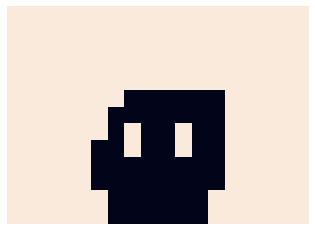

In [107]:
target = targets[5]
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(np.rot90(target_maps[target]))
trajectory_graph(target_name=target, rep = 0)
trajectory_graph(target_name=target, rep = 1)
trajectory_graph(target_name=target, rep = 2)
trajectory_graph(target_name=target, rep = 3)

In [ ]:
importlib.reload(scoring)

In [47]:
target_maps = {}

with open(os.path.abspath('../results/csv/targetMaps.txt')) as json_file:
    target_maps = json.load(json_file)

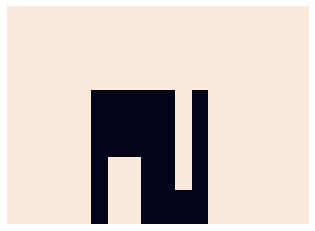

In [49]:
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(np.rot90(target_maps[targets[6]]))

In [96]:
dfic[(dfic.repetition==1)&(dfic.targetName==targets[5])].iloc[0]['discreteWorld']
dfic[(dfic.repetition==1)&(dfic.targetName==targets[5])].iloc[0]

targetName                                              hand_selected_011
gameID                          0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959
blockNum                                                                1
repetition                                                              1
flatDiscreteWorld       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
usableDiscreteWorld     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...
rawF1DiscreteScore                                                    NaN
discreteWorld           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...
flatDiscreteWorldStr    0000000000000000000000000000000000000000000000...
Name: 65, dtype: object